In [11]:
import pandas as pd
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn.model_selection import TimeSeriesSplit, train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.preprocessing import StandardScaler    
from sklearn.pipeline import Pipeline
from skopt import BayesSearchCV

In [12]:
# Getting the block info dataset
dataset = pd.read_csv('./datasets/dataset.csv')

In [13]:
dataset.columns

Index(['Unnamed: 0', 'block_base_fee', 'difficulty', 'gas_limit', 'gas_used',
       'number', 'size', 'time', 'total_difficulty', '0.25 Tip (Gwei)',
       '0.75 Tip (Gwei)', 'AVG Tip (Gwei)', 'Block Base Fees (ETH)',
       'Block Tips (ETH)', 'Max Tip (Gwei)', 'Median Tip (Gwei)',
       'Min Tip (Gwei)', 'block_number'],
      dtype='object')

In [14]:
# 2317337 blocks 
len(dataset.index)

2317337

In [15]:
# Data type and column name transformantions 
dataset = dataset.drop(columns=['block_number'])
dataset = dataset.drop(columns=['Unnamed: 0'])
dataset = dataset.rename(columns={"0.25 Tip (Gwei)":"Q1_tip", "0.75 Tip (Gwei)":"Q3_tip", "AVG Tip (Gwei) ":"avg_tip", "Block Base Fees (ETH)":"block_base_fees_eth", "Block Tips (ETH)":"block_tips_eth", "Max Tip (Gwei)": "max_tip", "Median Tip (Gwei)": "median_tip", "Min Tip (Gwei)":"min_tip","AVG Tip (Gwei)":"avg_tip"})
dataset['time'] = pd.to_datetime(dataset['time'])
dataset['time'] = dataset['time'].dt.strftime('%Y-%m-%d %H:%M:00')
#dataset['time'] = dataset['time'].dt.floor('Min')
dataset['time'] = pd.to_datetime(dataset['time'])

In [16]:
dataset

,block_base_fee,difficulty,gas_limit,gas_used,number,size,time,total_difficulty,Q1_tip,Q3_tip,avg_tip,block_base_fees_eth,block_tips_eth,max_tip,median_tip,min_tip
0,1000000000,7742494561645080,30029122,30025257,12965000,584,2021-08-05 12:33:00,28494409340649014490153,22.000000,32.000000,35.122037,0.030025,0.813216,1558.000000,25.000000,22.000000
1,1124967822,7742495635386904,29999798,29985144,12965001,579,2021-08-05 12:33:00,28494417083144649877057,25.875032,44.900606,33.106784,0.033732,0.926795,98.875032,28.380162,21.375032
2,1265451421,7738716193681762,29970503,29950343,12965002,577,2021-08-05 12:34:00,28494424821860843558819,20.734549,25.484549,24.922555,0.037901,0.712779,77.734549,20.734549,20.734549
3,1423420054,7742495937440032,29941236,29933895,12965003,586,2021-08-05 12:34:00,28494432564356780998851,25.576580,34.876580,31.892835,0.042609,0.965993,128.576580,26.576580,0.000000
4,1601260312,7742497011181856,29911998,29895283,12965004,579,2021-08-05 12:34:00,28494440306853792180707,31.273740,45.398740,49.536780,0.047870,1.400710,498.398740,45.398740,28.098740
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2317332,15429869588,12011638584426950,30000000,28150948,15282332,586,2022-08-05 12:32:00,55656481592363825782644,1.500000,4.417552,5.822693,0.434365,0.130254,104.570130,2.000000,1.000000
2317333,17120848026,12005842246001134,30000000,3846298,15282333,579,2022-08-05 12:33:00,55656493598206071783778,1.696058,4.000000,3.776143,0.065852,0.009934,14.573996,2.426766,1.000000
2317334,15529507719,12011773193137050,30000000,12975312,15282334,579,2022-08-05 12:33:00,55656505609979264920828,1.500000,4.925271,5.430084,0.201500,0.066612,147.495325,2.072444,0.000000
2317335,15267487653,12017707036243247,30000000,9966549,15282335,588,2022-08-05 12:33:00,55656517627686301164075,1.500000,3.505081,3.862013,0.152164,0.042536,49.670078,2.000000,0.000000


In [17]:
# eth price dataset from Binance
eth_price = pd.read_csv('./datasets/eth_price.csv')
eth_price

,Unnamed: 0,datetime,eth_price
0,0,2021-08-05 12:33:00,2615.68
1,1,2021-08-05 12:34:00,2608.04
2,2,2021-08-05 12:35:00,2615.22
3,3,2021-08-05 12:36:00,2620.99
4,4,2021-08-05 12:37:00,2618.12
...,...,...,...
525995,525995,2022-08-05 19:08:00,1667.74
525996,525996,2022-08-05 19:09:00,1668.26
525997,525997,2022-08-05 19:10:00,1669.79
525998,525998,2022-08-05 19:11:00,1670.99


In [18]:
# Data type and column name transformantions 
eth_price['datetime'] = pd.to_datetime(eth_price['datetime'])
eth_price = eth_price[eth_price['datetime'] <= '2022-08-05 12:33:00']
eth_price = eth_price.rename(columns={'datetime': 'time'})
eth_price = eth_price.drop(columns=['Unnamed: 0'])
eth_price = eth_price.drop_duplicates(subset=['time'])

# Join dataset and eth price
ds_aux = dataset.merge(eth_price, on='time', how='left', indicator=True)


# There are gaps in the Binance API, so we get the last known eth price value and we insert that into empty timestamps
empty_values = ds_aux[ds_aux['_merge'] == 'left_only']
for row in empty_values.iterrows():
    i = 1
    price = 0
    while price == 0:
        if math.isnan(ds_aux.loc[row[0]-i]['eth_price']):
            i=i+1
        else:
            price=ds_aux.loc[row[0]-i]['eth_price']
    ds_aux.at[row[0],'eth_price'] = price


eth_price

,time,eth_price
0,2021-08-05 12:33:00,2615.68
1,2021-08-05 12:34:00,2608.04
2,2021-08-05 12:35:00,2615.22
3,2021-08-05 12:36:00,2620.99
4,2021-08-05 12:37:00,2618.12
...,...,...
525596,2022-08-05 12:29:00,1717.24
525597,2022-08-05 12:30:00,1699.70
525598,2022-08-05 12:31:00,1698.53
525599,2022-08-05 12:32:00,1694.59


In [19]:
dataset = ds_aux
dataset = dataset.drop(columns=['_merge'])
# Drop empty blocks with no tip data 
dataset = dataset.dropna()

# Apply log to big numbers such as difficulty and total_difficulty so it doesn't mess with other inferior values
dataset['total_difficulty'] = dataset["total_difficulty"].apply(np.float64)
#dataset['total_difficulty'] = dataset["total_difficulty"].apply(np.float128) # For non Windows executions
dataset['difficulty'] = dataset["difficulty"].apply(int)
dataset['difficulty'] = np.log10(dataset['difficulty'])
dataset['total_difficulty'] = np.log10(dataset['total_difficulty'])

dataset

,block_base_fee,difficulty,gas_limit,gas_used,number,size,time,total_difficulty,Q1_tip,Q3_tip,avg_tip,block_base_fees_eth,block_tips_eth,max_tip,median_tip,min_tip,eth_price
0,1000000000,15.888881,30029122,30025257,12965000,584,2021-08-05 12:33:00,22.454760,22.000000,32.000000,35.122037,0.030025,0.813216,1558.000000,25.000000,22.000000,2615.68
1,1124967822,15.888881,29999798,29985144,12965001,579,2021-08-05 12:33:00,22.454760,25.875032,44.900606,33.106784,0.033732,0.926795,98.875032,28.380162,21.375032,2615.68
2,1265451421,15.888669,29970503,29950343,12965002,577,2021-08-05 12:34:00,22.454760,20.734549,25.484549,24.922555,0.037901,0.712779,77.734549,20.734549,20.734549,2608.04
3,1423420054,15.888881,29941236,29933895,12965003,586,2021-08-05 12:34:00,22.454760,25.576580,34.876580,31.892835,0.042609,0.965993,128.576580,26.576580,0.000000,2608.04
4,1601260312,15.888881,29911998,29895283,12965004,579,2021-08-05 12:34:00,22.454760,31.273740,45.398740,49.536780,0.047870,1.400710,498.398740,45.398740,28.098740,2608.04
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2317332,15429869588,16.079602,30000000,28150948,15282332,586,2022-08-05 12:32:00,22.745516,1.500000,4.417552,5.822693,0.434365,0.130254,104.570130,2.000000,1.000000,1694.59
2317333,17120848026,16.079393,30000000,3846298,15282333,579,2022-08-05 12:33:00,22.745516,1.696058,4.000000,3.776143,0.065852,0.009934,14.573996,2.426766,1.000000,1696.40
2317334,15529507719,16.079607,30000000,12975312,15282334,579,2022-08-05 12:33:00,22.745516,1.500000,4.925271,5.430084,0.201500,0.066612,147.495325,2.072444,0.000000,1696.40
2317335,15267487653,16.079822,30000000,9966549,15282335,588,2022-08-05 12:33:00,22.745516,1.500000,3.505081,3.862013,0.152164,0.042536,49.670078,2.000000,0.000000,1696.40


In [20]:
def reorder_dataset(dataset, n):
    
    ds = dataset.copy()
    for i in range (1,n+1):
        ds['block_base_fee_'+str(i)] = np.nan
        ds['difficulty_'+str(i)] = np.nan
        ds['gas_limit_'+str(i)] = np.nan
        ds['gas_used_'+str(i)] = np.nan
        ds['size_'+str(i)] = np.nan
        ds['total_difficulty_'+str(i)] = np.nan
        ds['Q1_tip_'+str(i)] = np.nan
        ds['Q3_tip_'+str(i)] = np.nan
        ds['avg_tip_'+str(i)] = np.nan
        ds['block_base_fees_eth_'+str(i)] = np.nan
        ds['block_tips_eth_'+str(i)] = np.nan
        ds['max_tip_'+str(i)] = np.nan
        ds['median_tip_'+str(i)] = np.nan
        ds['eth_price_'+str(i)] = np.nan

    for i in range (1,n+1):        
        ds['block_base_fee_'+str(i)] = ds['block_base_fee'].shift(i)
        ds['difficulty_'+str(i)] = ds['difficulty'].shift(i)
        ds['gas_limit_'+str(i)] = ds['gas_limit'].shift(i)
        ds['gas_used_'+str(i)] = ds['gas_used'].shift(i)
        ds['size_'+str(i)] = ds['size'].shift(i)
        ds['total_difficulty_'+str(i)] = ds['total_difficulty'].shift(i)
        ds['Q1_tip_'+str(i)] = ds['Q1_tip'].shift(i)
        ds['Q3_tip_'+str(i)] = ds['Q3_tip'].shift(i)
        ds['avg_tip_'+str(i)] = ds['avg_tip'].shift(i)
        ds['block_base_fees_eth_'+str(i)] = ds['block_base_fees_eth'].shift(i)
        ds['block_tips_eth_'+str(i)] = ds['block_tips_eth'].shift(i)
        ds['max_tip_'+str(i)] = ds['max_tip'].shift(i)
        ds['median_tip_'+str(i)] = ds['median_tip'].shift(i)
        ds['eth_price_'+str(i)] = ds['eth_price'].shift(i)
    
    return ds

dataset_n3 = reorder_dataset(dataset,3)

In [21]:
dataset_n3 = dataset_n3.drop(columns = ['block_base_fee', 'difficulty', 'gas_limit', 'gas_used', 'size', 'total_difficulty', 'Q1_tip',
                            'Q3_tip', 'avg_tip', 'block_base_fees_eth', 'block_tips_eth', 'max_tip', 'median_tip','eth_price'])

In [22]:
# Drop not relevant columns
dataset_n3 = dataset_n3.drop(columns=['time'])

#### Drop blocks without full history ####
dataset_n3 = dataset_n3.dropna()

In [23]:
dataset_n3

,number,min_tip,block_base_fee_1,difficulty_1,gas_limit_1,gas_used_1,size_1,total_difficulty_1,Q1_tip_1,Q3_tip_1,...,size_3,total_difficulty_3,Q1_tip_3,Q3_tip_3,avg_tip_3,block_base_fees_eth_3,block_tips_eth_3,max_tip_3,median_tip_3,eth_price_3
3,12965003,0.000000,1.265451e+09,15.888669,29970503.0,29950343.0,577.0,22.454760,20.734549,25.484549,...,584.0,22.454760,22.000000,32.000000,35.122037,0.030025,0.813216,1558.000000,25.000000,2615.68
4,12965004,28.098740,1.423420e+09,15.888881,29941236.0,29933895.0,586.0,22.454760,25.576580,34.876580,...,579.0,22.454760,25.875032,44.900606,33.106784,0.033732,0.926795,98.875032,28.380162,2615.68
5,12965005,14.918806,1.601260e+09,15.888881,29911998.0,29895283.0,579.0,22.454760,31.273740,45.398740,...,577.0,22.454760,20.734549,25.484549,24.922555,0.037901,0.712779,77.734549,20.734549,2608.04
6,12965006,25.973788,1.801194e+09,15.888457,29882789.0,29874058.0,586.0,22.454760,27.898806,45.198806,...,586.0,22.454760,25.576580,34.876580,31.892835,0.042609,0.965993,128.576580,26.576580,2608.04
7,12965007,23.720677,2.026212e+09,15.888245,29911970.0,29902274.0,569.0,22.454760,26.973788,36.473788,...,579.0,22.454760,31.273740,45.398740,49.536780,0.047870,1.400710,498.398740,45.398740,2608.04
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2317332,15282332,1.000000,1.484742e+10,16.079600,30000000.0,19707465.0,568.0,22.745516,1.500000,4.000000,...,579.0,22.745515,1.500000,2.628614,4.333882,0.439172,0.089707,55.238483,2.000000,1694.59
2317333,15282333,1.000000,1.542987e+10,16.079602,30000000.0,28150948.0,586.0,22.745516,1.500000,4.417552,...,583.0,22.745516,1.500000,3.423904,6.308426,0.041201,0.010356,83.423904,2.000000,1694.59
2317334,15282334,0.000000,1.712085e+10,16.079393,30000000.0,3846298.0,579.0,22.745516,1.696058,4.000000,...,568.0,22.745516,1.500000,4.000000,3.646355,0.292605,0.056053,25.412578,2.000000,1694.59
2317335,15282335,0.000000,1.552951e+10,16.079607,30000000.0,12975312.0,579.0,22.745516,1.500000,4.925271,...,586.0,22.745516,1.500000,4.417552,5.822693,0.434365,0.130254,104.570130,2.000000,1694.59


In [24]:
X = dataset_n3.drop('min_tip', axis=1)
y = dataset_n3['min_tip']
X = X.drop('number', axis=1)

In [25]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.99, random_state=10)

# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'rf__n_estimators': n_estimators,
               'rf__max_features': max_features,
               'rf__max_depth': max_depth,
               'rf__min_samples_split': min_samples_split,
               'rf__min_samples_leaf': min_samples_leaf,
               'rf__bootstrap': bootstrap}
print(random_grid)

# create pipeline with a scaler 
steps = [('rf', RandomForestRegressor())]
pipeline = Pipeline(steps)

{'rf__n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000], 'rf__max_features': ['auto', 'sqrt'], 'rf__max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None], 'rf__min_samples_split': [2, 5, 10], 'rf__min_samples_leaf': [1, 2, 4], 'rf__bootstrap': [True, False]}


In [26]:
# Use the random grid to search for best hyperparameters

tscv = TimeSeriesSplit(n_splits=3, test_size=5000, gap=3)

# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores

rf_bayes = BayesSearchCV(pipeline, random_grid, n_iter = 10, cv = tscv, verbose=100, random_state=10, n_jobs = -1)

In [27]:
# Fit the random search model
rf_bayes.fit(X_train, y_train)
rf_bayes.best_score_
rf_bayes.best_params_

Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits


OrderedDict([('rf__bootstrap', False),
             ('rf__max_depth', 40),
             ('rf__max_features', 'sqrt'),
             ('rf__min_samples_leaf', 2),
             ('rf__min_samples_split', 5),
             ('rf__n_estimators', 2000)])

In [30]:
rf_bayes.best_score_

0.45871558825898906

In [31]:
rf_bayes.best_estimator_

Pipeline(steps=[('rf',
                 RandomForestRegressor(bootstrap=False, max_depth=40,
                                       max_features='sqrt', min_samples_leaf=2,
                                       min_samples_split=5,
                                       n_estimators=2000))])

In [32]:
X = dataset_n3.drop('min_tip', axis=1)
X = X.drop('number', axis=1)
y = dataset_n3['min_tip'],

scaler = StandardScaler()
X = scaler.fit_transform(X)

rf = RandomForestRegressor(bootstrap=False, max_depth=40, max_features='sqrt',
                      min_samples_leaf=2, min_samples_split=5,
                      n_estimators=2000,n_jobs=-1)


rf.fit(X,y)

RandomForestRegressor(bootstrap=False, max_depth=40, max_features='sqrt',
                      min_samples_leaf=2, min_samples_split=5,
                      n_estimators=2000, n_jobs=-1)

In [33]:
#### Real data validation ####
# Getting the block info dataset
dataset_validation = pd.read_csv('./datasets/dataset_validation.csv')

# Data type and column name transformantions 
dataset_validation = dataset_validation.drop(columns=['block_number'])
dataset_validation = dataset_validation.drop(columns=['Unnamed: 0'])
dataset_validation = dataset_validation.rename(columns={"0.25 Tip (Gwei)":"Q1_tip", "0.75 Tip (Gwei)":"Q3_tip", "AVG Tip (Gwei) ":"avg_tip", "Block Base Fees (ETH)":"block_base_fees_eth", "Block Tips (ETH)":"block_tips_eth", "Max Tip (Gwei)": "max_tip", "Median Tip (Gwei)": "median_tip", "Min Tip (Gwei)":"min_tip","AVG Tip (Gwei)":"avg_tip"})
dataset_validation['time'] = pd.to_datetime(dataset_validation['time'])
dataset_validation['time'] = dataset_validation['time'].dt.strftime('%Y-%m-%d %H:%M:00')
dataset_validation['time'] = pd.to_datetime(dataset_validation['time'])

In [34]:
# eth price dataset from Binance
eth_price_validation = pd.read_csv('./datasets/eth_price_validation.csv')

# Data type and column name transformantions 
eth_price_validation['datetime'] = pd.to_datetime(eth_price_validation['datetime'])
eth_price_validation = eth_price_validation[eth_price_validation['datetime'] <= '2022-08-08 12:25:00']
eth_price_validation = eth_price_validation.rename(columns={'datetime': 'time'})
eth_price_validation = eth_price_validation.drop(columns=['Unnamed: 0'])
eth_price_validation = eth_price_validation.drop_duplicates(subset=['time'])

# Join dataset and eth price
ds_aux = dataset_validation.merge(eth_price_validation, on='time', how='left', indicator=True)


# There are gaps in the Binance API, so we get the last known eth price value and we insert that into empty timestamps
empty_values = ds_aux[ds_aux['_merge'] == 'left_only']
for row in empty_values.iterrows():
    i = 1
    price = 0
    while price == 0:
        if math.isnan(ds_aux.loc[row[0]-i]['eth_price']):
            i=i+1
        else:
            price=ds_aux.loc[row[0]-i]['eth_price']
    ds_aux.at[row[0],'eth_price'] = price


eth_price_validation

,time,eth_price
0,2022-08-07 01:50:00,1677.45
1,2022-08-07 01:51:00,1677.47
2,2022-08-07 01:52:00,1676.72
3,2022-08-07 01:53:00,1676.46
4,2022-08-07 01:54:00,1676.78
...,...,...
1995,2022-08-08 11:05:00,1769.00
1996,2022-08-08 11:06:00,1770.11
1997,2022-08-08 11:07:00,1770.65
1998,2022-08-08 11:08:00,1771.20


In [36]:
dataset_validation = ds_aux
dataset_validation = dataset_validation.drop(columns=['_merge'])
# Drop empty blocks with no tip data 
dataset_validation = dataset.dropna()

# Aplly log to big numbers such as difficulty and total_difficulty so it doesn't mess with other inferior values
dataset_validation['total_difficulty'] = dataset_validation["total_difficulty"].apply(np.float64)
#dataset_validation['total_difficulty'] = dataset_validation["total_difficulty"].apply(np.float128) # For non Windows executions
dataset_validation['difficulty'] = dataset_validation["difficulty"].apply(int)
dataset_validation['difficulty'] = np.log10(dataset_validation['difficulty'])
dataset_validation['total_difficulty'] = np.log10(dataset_validation['total_difficulty'])


dataset_validation

,block_base_fee,difficulty,gas_limit,gas_used,number,size,time,total_difficulty,Q1_tip,Q3_tip,avg_tip,block_base_fees_eth,block_tips_eth,max_tip,median_tip,min_tip,eth_price
0,1000000000,1.176091,30029122,30025257,12965000,584,2021-08-05 12:33:00,1.351308,22.000000,32.000000,35.122037,0.030025,0.813216,1558.000000,25.000000,22.000000,2615.68
1,1124967822,1.176091,29999798,29985144,12965001,579,2021-08-05 12:33:00,1.351308,25.875032,44.900606,33.106784,0.033732,0.926795,98.875032,28.380162,21.375032,2615.68
2,1265451421,1.176091,29970503,29950343,12965002,577,2021-08-05 12:34:00,1.351308,20.734549,25.484549,24.922555,0.037901,0.712779,77.734549,20.734549,20.734549,2608.04
3,1423420054,1.176091,29941236,29933895,12965003,586,2021-08-05 12:34:00,1.351308,25.576580,34.876580,31.892835,0.042609,0.965993,128.576580,26.576580,0.000000,2608.04
4,1601260312,1.176091,29911998,29895283,12965004,579,2021-08-05 12:34:00,1.351308,31.273740,45.398740,49.536780,0.047870,1.400710,498.398740,45.398740,28.098740,2608.04
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2317332,15429869588,1.204120,30000000,28150948,15282332,586,2022-08-05 12:32:00,1.356896,1.500000,4.417552,5.822693,0.434365,0.130254,104.570130,2.000000,1.000000,1694.59
2317333,17120848026,1.204120,30000000,3846298,15282333,579,2022-08-05 12:33:00,1.356896,1.696058,4.000000,3.776143,0.065852,0.009934,14.573996,2.426766,1.000000,1696.40
2317334,15529507719,1.204120,30000000,12975312,15282334,579,2022-08-05 12:33:00,1.356896,1.500000,4.925271,5.430084,0.201500,0.066612,147.495325,2.072444,0.000000,1696.40
2317335,15267487653,1.204120,30000000,9966549,15282335,588,2022-08-05 12:33:00,1.356896,1.500000,3.505081,3.862013,0.152164,0.042536,49.670078,2.000000,0.000000,1696.40


In [37]:
dataset_validation = reorder_dataset(dataset_validation,3)

dataset_validation = dataset_validation.drop(columns = ['block_base_fee', 'difficulty', 'gas_limit', 'gas_used', 'size', 'total_difficulty', 'Q1_tip',
                            'Q3_tip', 'avg_tip', 'block_base_fees_eth', 'block_tips_eth', 'max_tip', 'median_tip','eth_price'])

# Drop not relevant columns
dataset_validation = dataset_validation.drop(columns=['time'])

#### Drop blocks without full history ####
dataset_validation = dataset_validation.dropna()

In [38]:
y_validation = dataset_validation['min_tip']
X_validation = dataset_validation.drop('min_tip', axis=1)
X_validation = X_validation.drop('number', axis=1)

scaler_validation = StandardScaler()
X_validation = scaler_validation.fit_transform(X_validation)

y_val_pred = rf.predict(X_validation)
y_val_pred = np.maximum(y_val_pred, 0.)

print('Accuracy for model with info for 3 blocks with log: ', rf.score(X_validation, y_validation))
print('mean_squared_error for model with info for 3 blocks with log: ', mean_squared_error(y_validation, y_val_pred))
print('mean_absolute_error for model with info for 3 blocks with log: ', mean_absolute_error(y_validation, y_val_pred))

Accuracy for model with info for 3 blocks with log:  0.8770717329906832
mean_squared_error for model with info for 3 blocks with log:  220.44759095446167
mean_absolute_error for model with info for 3 blocks with log:  0.7700798588325609


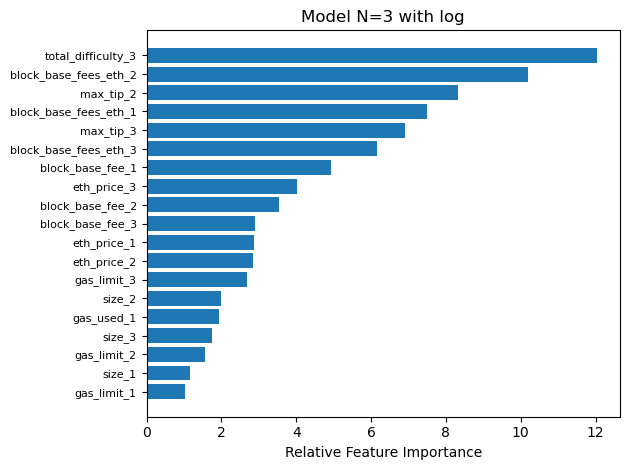

In [39]:
column_names = np.array(dataset_validation.columns)
column_names = np.delete(column_names,0) #number
column_names = np.delete(column_names,0) #min_tip

feature_importance = abs(rf.feature_importances_)
total_feature_importance =  feature_importance.sum()
feature_importance = 100.0 * (feature_importance / total_feature_importance)
column_names_ids = np.argsort(feature_importance)
feature_importance = np.array([i for i in feature_importance if i>1])
column_names_ids = column_names_ids[:len(feature_importance)]
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5

featfig = plt.figure()
featax = featfig.add_subplot(1, 1, 1)
featax.barh(pos, feature_importance[sorted_idx], align='center')
featax.set_yticks(pos)
featax.set_yticklabels(column_names[column_names_ids], fontsize=8)
featax.set_xlabel('Relative Feature Importance')

plt.title('Model N=3 with log')

plt.tight_layout()   
plt.show()

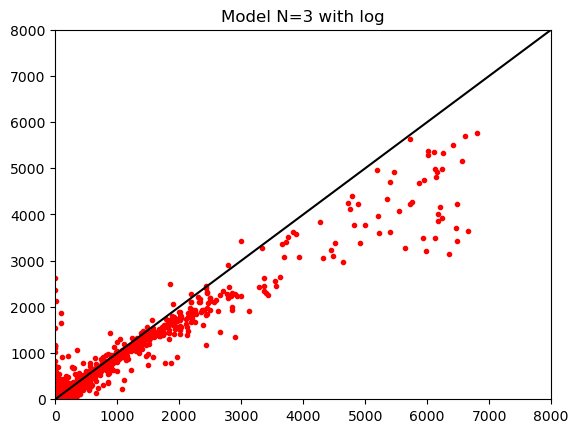

In [40]:
line=np.linspace(0,np.max(y_validation)+1,len(y_validation)) 

plt.plot(y_validation,y_val_pred,'r.') # x vs y
plt.plot(line,line,'k-') # identity line

plt.title('Model N=3 with log')


plt.xlim(0,8000)
plt.ylim(0,8000)
plt.show()

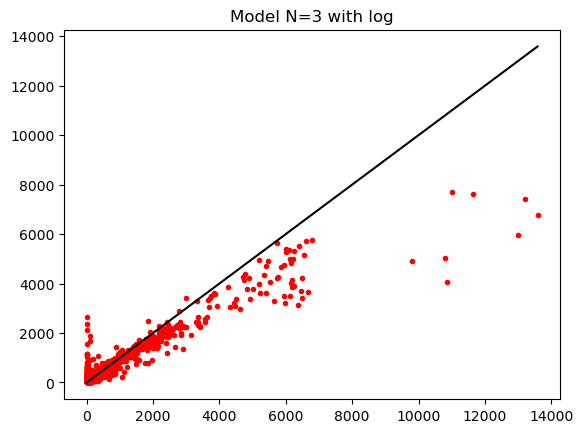

In [41]:
line=np.linspace(0,np.max(y_validation)+1,len(y_validation)) 

plt.plot(y_validation,y_val_pred,'r.') # x vs y
plt.plot(line,line,'k-') # identity line

plt.title('Model N=3 with log')


plt.show()

In [42]:
y_val_array = np.array(y_validation)
biggest_error=0
for i in range(0,len(y_val_array)):
    if biggest_error < abs(y_val_pred[i] - y_val_array[i]):
        biggest_error= abs(y_val_pred[i] - y_val_array[i])

biggest_error

7035.409464253755

In [43]:
y_val_array = np.array(y_validation)
lower_values=0
for i in range(0,len(y_val_array)):
    if y_val_pred[i] <= y_val_array[i]:
        lower_values=lower_values+1

print("Amount of predicted min tip that wouldn't be enough to go through:" , lower_values)
print("Percetage of predicted min tip that wouldn't be enough to go through: ", (lower_values/len(y_val_array)*100), "%")

Amount of predicted min tip that wouldn't be enough to go through: 900657
Percetage of predicted min tip that wouldn't be enough to go through:  39.80065578986442 %


In [44]:
errors_validation = []
for i in range(0,len(y_val_array)):
    if abs(y_val_pred[i] - y_val_array[i]) <= 100:
        errors_validation.append(y_val_pred[i] - y_val_array[i])

erros_validation = np.array(errors_validation)

Text(0, 0.5, '# blocks')

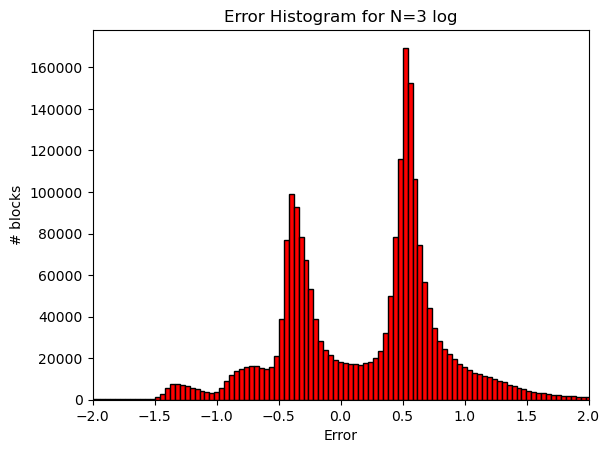

In [45]:
plt.hist(errors_validation, bins = 5000, color = 'red', edgecolor = 'black')
plt.xlim(-2,2)
plt.title('Error Histogram for N=3 log')
plt.xlabel('Error')
plt.ylabel('# blocks')

In [46]:
#pd.DataFrame(y_validation).to_csv("validation_y.csv")
pd.DataFrame(y_val_array).to_csv("rf_n3_log.csv")